# ROCKET Interpretability with sktime-xai

This notebook shows how to **peek inside the ROCKET black box**.

We demonstrate two complementary views:
1. **Top-K Kernel Activation** — which specific random kernels matter most for a prediction.
2. **Temporal Saliency Map** — a heatmap showing *when* (which timesteps) the model pays attention.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_gunpoint
from sktime.classification.kernel_based import RocketClassifier
from sktime_xai.classification._rocket_explainer import RocketExplainer, RocketExplanation

## 1 — Train ROCKET on GunPoint

**GunPoint** is a classic UCR dataset: distinguish whether a person is *drawing a gun* or *pointing a finger*.

In [2]:
X_train, y_train = load_gunpoint(split="train")
X_test, y_test = load_gunpoint(split="test")

clf = RocketClassifier(num_kernels=500, random_state=42)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(f"Test accuracy: {score:.1%}")

Test accuracy: 100.0%


## 2 — Create the Explainer

`RocketExplainer` automatically locates the fitted components inside `RocketClassifier`:
- The **Rocket transformer** (random convolutional kernels)
- The **RidgeClassifierCV** (linear weights over kernel features)

In [3]:
explainer = RocketExplainer(clf)
print(f"Linear model:  {type(explainer.linear_model).__name__}")
print(f"Transformer:   {type(explainer.transformer).__name__}")
print(f"Rocket object: {type(explainer._rocket_object).__name__}")
print(f"Num kernels:   {explainer._rocket_object.num_kernels}")

Linear model:  RidgeClassifierCV
Transformer:   TransformerPipeline
Rocket object: Rocket
Num kernels:   500


## 3 — Top-K Kernel Activations

Pick a test instance and see which **3 kernels** most strongly push the model towards a class.

Each subplot shows:
- **Grey** = original time series
- **Red** = kernel activation (convolution output)
- **★** = max activation point (for `Max`-typed features)
- **Blue dashed** = zero threshold (for `PPV`-typed features)

In [5]:
idx = 0
X_instance = X_test.iloc[[idx]]
true_class = y_test[idx]
pred_class = clf.predict(X_instance)[0]
print(f"Instance {idx}  |  True: {true_class}  |  Predicted: {pred_class}")

explanation = explainer.explain(X_instance, class_index=0, top_k=3)

for info in explanation.top_kernels_info:
    print(f"  Kernel {info['kernel_idx']:3d}  {info['type']:>3s}  "
          f"contribution={info['contribution']:+.3f}  "
          f"weight={info['weight']:+.3f}  value={info['value']:.3f}")

Instance 0  |  True: 1  |  Predicted: 1
  Kernel 212  Max  contribution=+2.271  weight=+0.019  value=117.030
  Kernel   2  PPV  contribution=+1.179  weight=+0.017  value=69.900
  Kernel 196  Max  contribution=+1.018  weight=+0.012  value=86.560


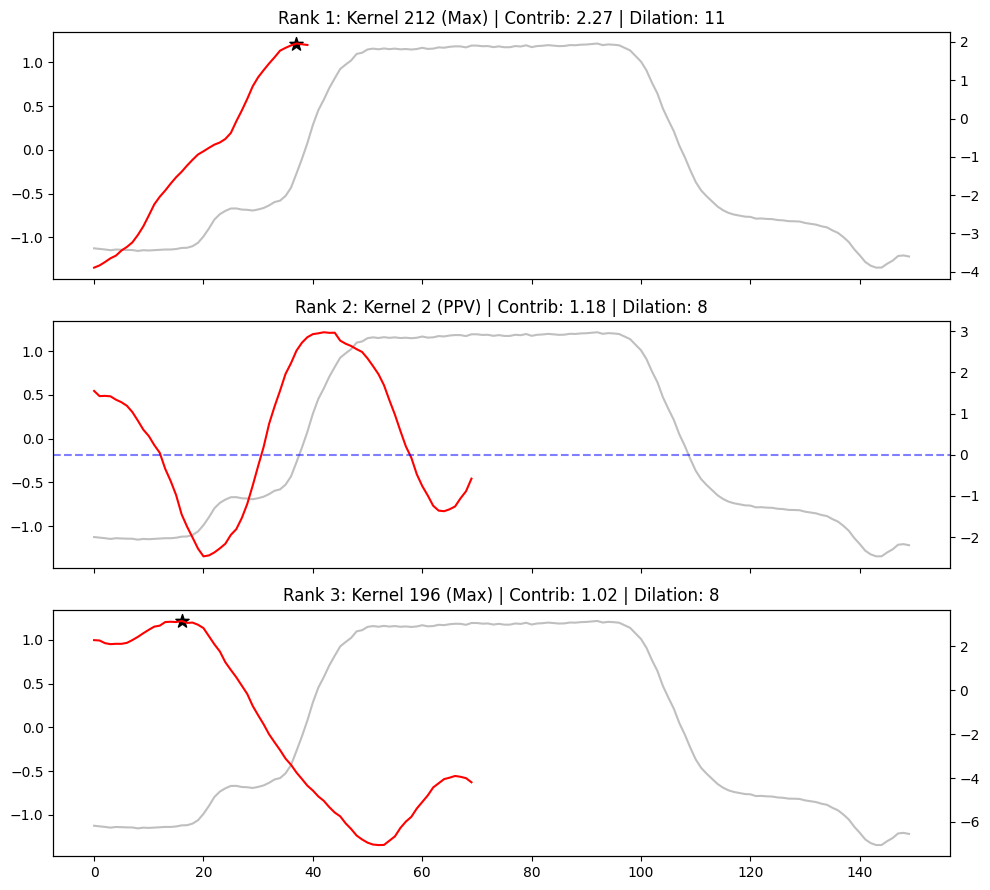

In [6]:
fig = explanation.plot()
plt.show()

## 4 — Temporal Saliency Map  ✨

This aggregates **all kernel activations**, weighted by their linear model
coefficients, into a single per-timestep importance score.

Think of it as a **GradCAM analogue for ROCKET** — but using linear weights
instead of gradients (since ROCKET is not a neural network).

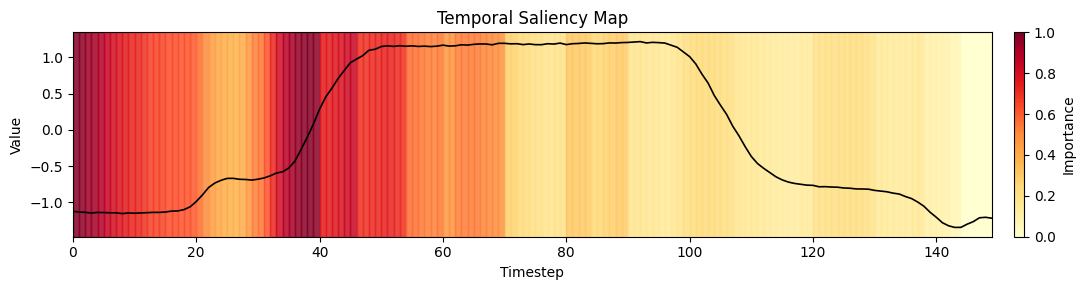

In [7]:
saliency = explainer.saliency_map(X_instance, class_index=0)

fig = RocketExplanation.plot_saliency(saliency)
plt.show()

**Reading the saliency map:**
- **Dark red** = high importance (the model's decision relies heavily on these timesteps)
- **Light yellow** = low importance
- The **black line** is the original signal

For GunPoint, you should see the model focusing on the critical motion
phase of the gesture.

## 5 — Compare Two Instances

Let's compare saliency maps for two different classes side-by-side.

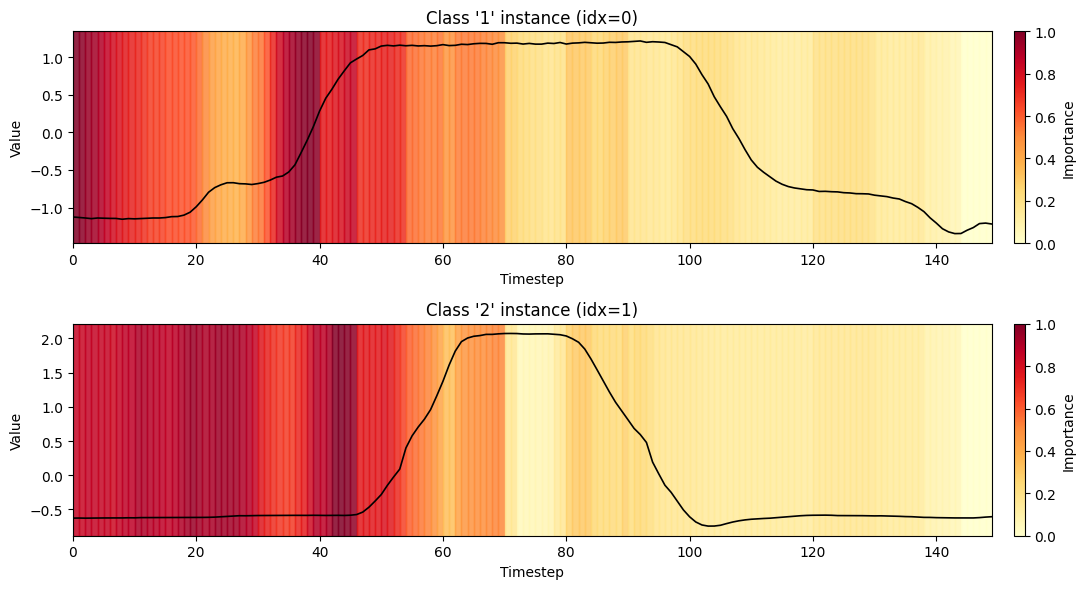

In [9]:
# Find one instance of each class
idx_class1 = int(np.where(y_test == '1')[0][0])
idx_class2 = int(np.where(y_test == '2')[0][0])

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sal1 = explainer.saliency_map(X_test.iloc[[idx_class1]], class_index=0)
sal2 = explainer.saliency_map(X_test.iloc[[idx_class2]], class_index=0)

RocketExplanation.plot_saliency(sal1, ax=axes[0])
axes[0].set_title(f"Class '1' instance (idx={idx_class1})")

RocketExplanation.plot_saliency(sal2, ax=axes[1])
axes[1].set_title(f"Class '2' instance (idx={idx_class2})")

plt.tight_layout()
plt.show()

---
## Summary

| Method | What it shows | Use case |
|---|---|---|
| `explain()` + `plot()` | Top-K individual kernels | Understand *which* patterns matter |
| `saliency_map()` + `plot_saliency()` | Per-timestep importance | Understand *when* the model looks |

Both methods work with any fitted `RocketClassifier` — no PyTorch required.